In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
from torch.utils.data import Dataset, DataLoader
import glob
import wandb
import os
import torch.optim as optimizers
import pandas as pd
from copy import deepcopy
from ml_collections import ConfigDict 
import tqdm
import torch.nn.functional as F
import torch
import torch.nn as nn
from collections import defaultdict
import yaml
from sklearn.metrics import roc_auc_score
import networkx as nx

import sys
sys.path.append("../../src")
import dfs_code 
from dfs_transformer import collate_downstream, DFSCodeSeq2SeqFC, Trainer
torch.multiprocessing.set_sharing_strategy('file_system')


Using backend: pytorch


In [3]:
graph_file = "/mnt/ssd/datasets/graphs/reddit_threads/reddit_edges.json"
label_file = "/mnt/ssd/datasets/graphs/reddit_threads/reddit_target.csv"
batch_size = 1000
rep = 1
max_edges = 50
n_samples = None

In [4]:
with open(graph_file, 'r') as f:
    graph_dict = json.load(f)
label_df = pd.read_csv(label_file)

In [5]:
label_df.head()

,id,target
0,0,0
1,1,1
2,2,0
3,3,1
4,4,0


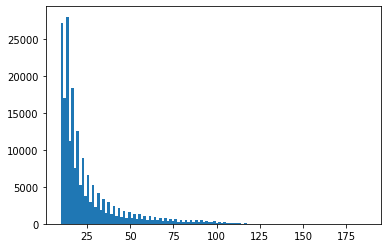

In [6]:
from matplotlib import pyplot as plt
n_edges = [len(graph) for graph in graph_dict.values()]
plt.hist(n_edges, bins='rice')
plt.show()

In [7]:
connected =  []
for graph in graph_dict.values():
    g = nx.Graph()
    g.add_edges_from(graph)
    connected += [nx.is_connected(g)]

In [8]:
connected = np.asarray(connected)

In [9]:
connected.sum()/len(connected)

1.0

In [10]:
def graph2labelledgraph(graph, use_dummy=False):
    graph = deepcopy(graph)
    node_ids = np.unique(graph).tolist()
    dummy = max(node_ids) + 1
    
    edge_labels = len(graph)*[0]
    edgeindex = []
    for e in graph:
        edgeindex += [e]
        edgeindex += [[e[1], e[0]]]
        edge_labels += [0]
    
    if use_dummy:
        for idx in node_ids:
            edgeindex += [[idx, dummy], [dummy, idx]]
            edge_labels += [1, 1]
        node_ids += [dummy]
    
    edgeindex = np.asarray(edgeindex).T
    
    node_labels = []
    for idx in node_ids:
        node_labels += [(edgeindex[0] == idx).sum()]
    return edgeindex, node_labels, edge_labels

In [11]:
def graph2labelledlinegraph(graph):
    raise NotImplementedError()

In [12]:
import networkx as nx

edgeindex, node_labels, edge_labels = graph2labelledgraph(graph)
g = nx.Graph()
g.add_edges_from(graph)

In [13]:
lg = nx.generators.line.line_graph(g)

In [14]:
nx.is_connected(lg)

True

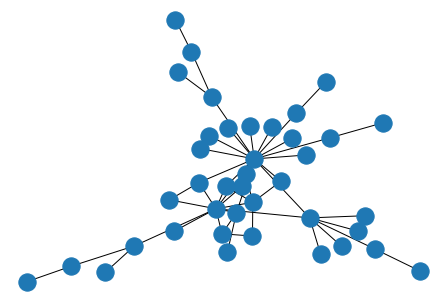

In [15]:
nx.draw(g)

In [16]:
graph = graph_dict['0']
code, index = dfs_code.min_dfs_code_from_edgeindex(*graph2labelledgraph(graph))

In [17]:
edgeindex, vlabels, elabels = graph2labelledgraph(graph)

In [18]:
code2, index2 = dfs_code.rnd_dfs_code_from_edgeindex(*graph2labelledgraph(graph))

In [19]:
class KarateClubDataset(Dataset):
    def __init__(self, graph_file, label_file, max_n = None, max_edges=50):
        self.graph_file = graph_file
        self.label_file = label_file
        with open(graph_file, 'r') as f:
            self.graph_dict = json.load(f)
        self.label_df = pd.read_csv(label_file)
        self.data = []
        self.maxn = max_n
        self.max_edges = max_edges
        self.preprocess()
    
    def preprocess(self):
        maxn = self.maxn
        maxdegree = 0
        edgeindex_list = []
        vlabels_list = []
        elabels_list = []
        label_list = self.label_df['target'][:maxn]
        for idx, (graph, label) in tqdm.tqdm(enumerate(zip(self.graph_dict.values(), self.label_df['target']))):  
            edgeindex, vlabels, elabels = graph2labelledgraph(graph)
            if len(elabels)//2 > self.max_edges:
                continue
            maxdegree = max(maxdegree, max(vlabels))
            edgeindex_list += [edgeindex]
            vlabels_list += [vlabels]
            elabels_list += [elabels]
            if maxn is not None:
                if idx >= maxn:
                    break
        self.maxdegree = maxdegree
        
        for idx, (edgeindex, vlabels, elabels, label) in tqdm.tqdm(enumerate(zip(edgeindex_list,
                                                                                vlabels_list,
                                                                                elabels_list, 
                                                                                label_list))):  
            node_features = F.one_hot(torch.tensor(vlabels), num_classes=maxdegree+1).float()
            edge_features = F.one_hot(torch.tensor(elabels), num_classes=2).float()
            #code, index = dfs_code.rnd_dfs_code_from_edgeindex(edgeindex, vlabels, elabels)
            self.data += [ConfigDict({"node_labels":torch.tensor(vlabels),
                                    "edge_labels":torch.tensor(elabels),
                                    "edge_index":torch.tensor(edgeindex, dtype=torch.long),
                                    #"min_dfs_code":torch.tensor(code),
                                    #"min_dfs_index":torch.tensor(index, dtype=torch.long),
                                    "node_features":node_features,
                                    "edge_features":edge_features,
                                    "y": torch.tensor(label, dtype=torch.float32),
                                    "idx":idx})]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
        

In [20]:
dataset = KarateClubDataset(graph_file, label_file, max_n=n_samples, max_edges=max_edges)

203088it [00:38, 5247.26it/s]
182788it [00:20, 9069.23it/s]


In [21]:
len(dataset)

182788

In [22]:
n = len(dataset)
n_train = int(0.8*n)
n_valid = 0
n_test = n - n_train - n_valid

perm = np.random.permutation(len(dataset))
train_idx = torch.tensor(perm[:n_train], dtype=torch.long)
valid_idx = torch.tensor(perm[n_train:n_train+n_valid].tolist(), dtype=torch.long)
test_idx = torch.tensor(perm[n_train+n_valid:].tolist(), dtype=torch.long)

In [23]:
ce = nn.BCEWithLogitsLoss() 

In [33]:
def collate_fn(dlist, use_min=False, rep=rep):
    dfs_codes = defaultdict(list)
    node_batch = [] 
    edge_batch = []
    y_batch = []
    rnd_code_batch = []
    
    for d in dlist:
        for r in range(rep):
            edge_features = d.edge_features.clone()
            if use_min:
                code = d.min_dfs_code.clone()
                index = d.min_dfs_index.clone()
            else:
                code, index = dfs_code.rnd_dfs_code_from_edgeindex(d.edge_index.numpy(), 
                                                                   d.node_labels.numpy().tolist(), 
                                                                   d.edge_labels.numpy().tolist())

                code = torch.tensor(np.asarray(code), dtype=torch.long)
                index = torch.tensor(np.asarray(index), dtype=torch.long)


            rnd_code_batch += [code]
            node_batch += [d.node_features.clone()]
            edge_batch += [edge_features]
            y_batch += [d.y.unsqueeze(0).clone()]

    y = torch.cat(y_batch).unsqueeze(1)

    
    for inp, nfeats, efeats in zip(rnd_code_batch, node_batch, edge_batch):
        dfs_codes['dfs_from'] += [inp[:, 0]]
        dfs_codes['dfs_to'] += [inp[:, 1]]
        atm_from_feats = nfeats[inp[:, -3]]
        atm_to_feats = nfeats[inp[:, -1]]
        bnd_feats = efeats[inp[:, -2]]
        dfs_codes['atm_from'] += [atm_from_feats]
        dfs_codes['atm_to'] += [atm_to_feats]
        dfs_codes['bnd'] += [bnd_feats]

    dfs_codes = {key: nn.utils.rnn.pad_sequence(values, padding_value=-1000).clone()
                 for key, values in dfs_codes.items()}
    return dfs_codes, y

In [34]:
trainloader = DataLoader(dataset, sampler=torch.utils.data.SubsetRandomSampler(train_idx), 
                         batch_size=batch_size, collate_fn=collate_fn, num_workers=8)
validloader = DataLoader(dataset, sampler=torch.utils.data.SubsetRandomSampler(valid_idx), 
                         batch_size=batch_size, collate_fn=collate_fn, num_workers=8)
testloader = DataLoader(dataset, sampler=torch.utils.data.SubsetRandomSampler(test_idx), 
                        batch_size=batch_size, collate_fn=collate_fn, num_workers=8)

In [35]:
class TransformerPlusHead(nn.Module):
    def __init__(self, encoder, n_classes, fingerprint='cls'):
        super(TransformerPlusHead, self).__init__()
        self.encoder = encoder
        #self.head = nn.Linear(encoder.get_n_encoding(fingerprint), n_classes)
        self.head = nn.Sequential(nn.Linear(encoder.get_n_encoding(fingerprint), 128),
                                  nn.ReLU(inplace=True),
                                  nn.Linear(128, 128),
                                  nn.ReLU(inplace=True),
                                  nn.Linear(128, n_classes))
        self.fingerprint = fingerprint
    
    def forward(self, dfs_code):
        #with torch.no_grad():
        features = self.encoder.encode(dfs_code, method=self.fingerprint)
        output = self.head(features)
        return output

In [36]:
with open("../../config/selfattn/model/bert.yaml") as file:
    m = ConfigDict(yaml.load(file, Loader=yaml.FullLoader))

In [37]:
m["n_atoms"] = int(dataset.maxdegree)+1
m["n_node_features"] = int(dataset.maxdegree)+1
m["n_bonds"] = 2
m["n_edge_features"] = 2
m["nlayers"] = 3
m["emb_dim"] = 50
m["nhead"] = 10
m["max_edges"] = max_edges
m["max_nodes"] = 60
m["dim_feedforward"] = 4*m["emb_dim"]
m["batch_size"] = batch_size
m["rep"] = rep
m["max_edges"] = max_edges
m["n_samples"] = n_samples
m["encoder_class"] = "DFSCodeEncoderLSTM"


encoder = DFSCodeSeq2SeqFC(**m)
model = TransformerPlusHead(encoder, 1)

In [38]:
def loss(pred, y, ce=ce):
    return ce(pred, y.float())

def auc(pred, y):
    return roc_auc_score(y.detach().cpu().numpy(), pred[:, 0].detach().cpu().numpy())
    

In [39]:
run = wandb.init(mode="online", project="karateclub-reddit-50", entity="dfstransformer", 
                 config=m.to_dict(), job_type="evaluation")

batch-loss,0.69302
loss,0.69287
batch-auc,0.51134
auc,0.50205
learning rate,0.0003
_runtime,41
_timestamp,1641913725
_step,233
train-loss,0.69289
train-auc,0.49921


batch-loss,▃▆▁▄▄▂▃▅▂▃▇▃▄▄▄▃▆▁▃▁▃▄▃▅▂▄▅▃▄▄▂▅▂█▂▄▃▅▂▃
loss,▁▆▆▅▄▃▄▅▅▅▆▆▅▆▆▆▆▆▆▆▅▆▅▆▆▄█▆█▇▆▇▅▆▆▆▆▆▆▆
batch-auc,▄▃▆▁▅▄▂▄▄▆▆▂▄▆▄▃▄█▅▄▄▅▃▅▄▆▅▃▃▇▄▅▃▅▅▅▂█▃▄
auc,▄▃▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▂▂▂█▆▆▄▄▃▄▃▃▃▃▂▃▃▃
learning rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train-loss,▁
train-auc,▁


wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [40]:
trainer = Trainer(model, trainloader, loss, metrics={'auc': auc}, lr=0.0003, validloader=testloader, 
                  es_period=10*n_train//batch_size, lr_adjustment_period=10*n_train//batch_size//4, wandb_run=run,
                  clip_gradient_norm=None)

In [ ]:
trainer.fit()

Epoch 1: loss 0.692931 0.4940:  16%|█▊         | 24/147 [00:07<00:17,  6.91it/s]